# Zero-Shot Protein Design Using ESM-2nv

*We thank Adrian Lange from A-Alpha Bio for originally contributing this recipe. This notebook has since been modified by NVIDIA.*

<div class="alert alert-block alert-info"> <b>NOTE</b> Note: This notebook has been tested on a single A100, and is compatible with BioNeMo Framework v1.7 and v1.8. The expected runtime is ~3 minutes on an A100, and less than 1 hour on an A1000.</div>

## Demo Objectives

1. **ESM-2nv Inference Functionality**
    * Objective: Perform inference on the pre-trained ESM-2nv model.
    * Steps: Download model checkpoints, instantiate an inference object, and generate hidden state representations and sequence embeddings from input protein sequences.
2. **Logit and Probability Extraction**
    * Objective: Obtain probability values of all possible tokens at each position in the amino acid sequence.
    * Steps: Access the BERT language model head, generate logits from hidden states, and transform them into probabilities.
3. **Protein Mutant Design**
    * Objective: Optimize an input protein sequence to align it more closely with naturally occurring protein variants.
    * Steps: Sequentially mask amino acids, extract per-position probabilities (and create a heatmap), analyze positions where single-point mutants have higher likelihood than wild-type, and develop new candidates.

## Background

ESM-2nv is a large-scale protein language model (PLM) trained on millions of protein sequences. It can capture complex patterns and relationships in protein sequences, allowing it to be used to predict likely amino acid substitutions at different positions. By leveraging ESM-2nv's masked language modeling (MLM) capabilities, we can identify potential mutations that may enhance a protein's properties or align it more closely with naturally occurring variants. ESM-2nv has 650M and 3B parameter versions - for this demo, we will be using ESM-2nv 3B.

## Setup

Ensure you have read through the [Getting Started](https://docs.nvidia.com/bionemo-framework/latest/#) section, can run the BioNeMo Framework docker container, and have configured the NGC Command Line Interface (CLI) within the container. It is assumed that this notebook is being executed from within the container. Additionally, this tutorial depends on the [ESM-2nv](https://docs.nvidia.com/bionemo-framework/latest/models/esm2-nv.html) model.

<div class="alert alert-block alert-info"> <b>NOTE</b> Some of the cells below generate long text output. We're using <pre>%%capture --no-display --no-stderr cell_output</pre> to suppress this output. Comment or delete this line in the cells below to restore full output.</div>

### Import Required Libraries

In [1]:
%%capture --no-display --no-stderr cell_output

import os

from bionemo.utils.hydra import load_model_config
from bionemo.model.protein.esm1nv.infer import ESM1nvInference

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Home Directory

Set the home directory as follows:

In [2]:
bionemo_home = "/workspace/bionemo"
os.environ['BIONEMO_HOME'] = bionemo_home
os.chdir(bionemo_home)

### Download Model Checkpoints

The following code will download the pre-trained model, `esm2nv_3B_converted.nemo`, from the NGC registry:

In [3]:
# Define the NGC CLI API KEY and ORG for the model download
# If these variables are not already set in the container, uncomment below to define and set API KEY and ORG
# api_key = <YOUR_API_KEY>
# ngc_cli_org = <YOUR_ORG>
# Update the environment variable
# os.environ['NGC_CLI_API_KEY'] = api_key
# os.environ['NGC_CLI_ORG'] = ngc_cli_org

# Set variables and paths for model and checkpoint
model_name = "esm2nv"
model_version = "esm2nv_3b" # for ESM-2nv 650M, write "esm2nv_650m"
actual_checkpoint_name = "esm2nv_3B_converted.nemo" # for ESM-2nv 650M, write "esm2nv_650M_converted.nemo"
model_path = os.path.join(bionemo_home, 'models')
checkpoint_path = os.path.join(model_path, actual_checkpoint_name)
config_path = os.path.join(bionemo_home, f'examples/protein/{model_name}/conf')
os.environ['MODEL_PATH'] = model_path

In [4]:
%%capture --no-display --no-stderr cell_output

if not os.path.exists(checkpoint_path):
    !python download_artifacts.py --model_dir ${BIONEMO_HOME}/models --models esm2nv_3b
else:
    print(f"Model {model_version} already exists at {model_path}.")

## ESM-2nv Inference

In this section, we will explore the key inference functionalities of the pre-trained model.

### Load Configurations

Here, we initiate an inferer of class `ESM1nvInference` (note that ESM-1nv and ESM-2nv share an inference class) and point it to a YAML file with base configurations for ESM-2nv inference. Some key configurations include:
* The desired checkpoints path (`esm2nv_3B_converted.nemo`)
* The HuggingFace tokenizer (`facebook/esm2_t36_3B_UR50D`)
* The model class (`ESM2nvModel`)

In [ ]:
%%capture --no-display --no-stderr cell_output

# Load starting config for ESM2nv inference
cfg = load_model_config(config_name = "infer.yaml", config_path = config_path)
cfg.model.tokenizer.model_name = "facebook/esm2_t36_3B_UR50D" # for ESM-2nv 650M, write "facebook/esm2_t33_650M_UR50D"
cfg.model.downstream_task.restore_from_path = checkpoint_path

# Create model object based on desired configuration
inferer = ESM1nvInference(cfg, interactive=True)

### ESM-2nv Inference Functions

Note that `inferer` is an object of the `ESM1nvInference` class, which contains the functionalities of `seq_to_hiddens()`, `hiddens_to_embedding()`, and `seq_to_embeddings()`. Because ESM-2nv is BERT-based (encoder-only), `hiddens_to_seq()` functionality is not available.

`seq_to_hiddens()`: This function queries the model to fetch the encoder hidden states for the input protein sequences. Along with `hidden_states`, `pad_masks` is returned and contains padding information. Note that the expected input to `seq_to_hiddens()` is a list.

In [6]:
seqs = [
    'MSLKRKNIALIPAAGIGVRFGADKPKQYVEIGSKTVLEHVL', # length: 41
    'MIQSQINRNIRLDLADAILLSKAKKDLSFAEIADGTGLA', # length: 39
]

hidden_states, pad_masks = inferer.seq_to_hiddens(seqs)
print(f"{hidden_states.shape=}")
print(f"{pad_masks.shape=}")

hidden_states.shape=torch.Size([2, 43, 2560])
pad_masks.shape=torch.Size([2, 43])


`hiddens_to_embedding()`: This function converts the hidden states (which are usually the output of each layer in a neural network) into fixed-size vector embeddings. This is done by removing the hidden state vectors corresponding to padding tokens, then averaging across the rest. This process is often used when the goal is to create a single vector representation from the hidden states of a model, which can be used for various sequence-level downstream tasks such as classification (e.g. subcellular localization) or regression (e.g. melting temperature prediction).

In [7]:
embeddings = inferer.hiddens_to_embedding(hidden_states = hidden_states, enc_mask = pad_masks)
print(f"{embeddings.shape=}")

embeddings.shape=torch.Size([2, 2560])


`seq_to_embeddings()`: This function takes input sequences and directly obtains their embeddings from the model. This is a more end-to-end approach that handles the entire process of converting raw input (like text) into vector embeddings. The key difference is that `hiddens_to_embedding()` works with already processed hidden states, while `seq_to_embeddings()` starts with raw input sequences and produces the final embeddings.

In [8]:
embeddings = inferer.seq_to_embeddings(seqs)
print(f"{embeddings.shape=}")

embeddings.shape=torch.Size([2, 2560])


## Obtaining Model Outputs (Logits and Probabilities)

ESM-2nv was trained with a Masked Language Modeling (MLM) objective. Thus, we are able to mask a position in an amino acid sequence and obtain values for the most probable amino acids at that position, based on the surrounding context. Let's sequentially obtain these values for every position in the sequence.

### Language Model Head

The model architecture is broken down into two components, the language model (which primarily consists of the input embedding and transformer encoder layers), and the model head. When extracting embeddings, we generally take the outputs of the final layer of the encoder. In our case, the model head is important because it is responsible for generating output predictions. 

In [9]:
inferer.model.model.lm_head

BertLMHead(
  (dense): Linear(in_features=2560, out_features=2560, bias=True)
  (layernorm): MixedFusedLayerNorm(torch.Size([2560]), eps=1e-05, elementwise_affine=True)
)

### Tokenizer

Let's also check the tokenizer vocabulary, stemming from [HuggingFace](https://huggingface.co/facebook/esm2_t36_3B_UR50D/blob/main/vocab.txt).

In [10]:
tokens = inferer.tokenizer.vocab
print(f"There are {inferer.tokenizer.vocab_size} unique tokens: {tokens}.")

There are 33 unique tokens: ['<cls>', '<pad>', '<eos>', '<unk>', 'L', 'A', 'G', 'V', 'S', 'E', 'R', 'T', 'I', 'D', 'P', 'K', 'Q', 'N', 'F', 'Y', 'M', 'H', 'W', 'C', 'X', 'B', 'U', 'Z', 'O', '.', '-', '<null_1>', '<mask>'].


Let's set aside the tokens corresponding to the 20 known amino acids.

In [26]:
aa_tokens = ['L', 'A', 'G', 'V', 'S', 'E', 'R', 'T', 'I', 'D', 'P', 'K', 'Q', 'N', 'F', 'Y', 'M', 'H', 'W', 'C']

aa_indices = [i for i, token in enumerate(tokens) if token in aa_tokens]
extra_indices = [i for i, token in enumerate(tokens) if token not in aa_tokens]

### Extract Logits and Probabilities

By passing the hidden state of an amino acid sequence through the BERT language model head, we can obtain output logits at each position and transform them into probabilities. 

Checking `type(inferer.model.model.lm_head)` shows that the language model head is a `BertLMHead` object, with source code stemming from within the [NeMo NLP Collection](https://github.com/NVIDIA/NeMo/blob/main/nemo/collections/nlp/models/language_modeling/megatron/bert/bert_model.py). The forward pass of the model head takes in two arguments, a `hidden_states` tensor and `word_embeddings_weight` matrix. The embedding weight matrix has a dimension of 128, with the first 33 positions corresponding to the amino acid vocabulary, followed by 95 paddings.

In [28]:
def hidden_states_to_probs(hidden_states, pad_masks):
    
    # Setup
    batch_size = hidden_states.size(0)
    logits_list = []
    probas_list = []
    
    # Perform batch inference
    lm_out = inferer.model.model.lm_head(hidden_states, inferer.model.model.word_embeddings_weight())

    # Sequentially convert LM outputs to logits and then probabilities
    for i in range(batch_size):
        logits = lm_out[i][pad_masks[i], :inferer.tokenizer.vocab_size]
        logits[:, extra_indices] = float('-inf') # force non-amino acid token probabilities to zero
        logits_list.append(logits)
        probas = torch.softmax(logits, dim=-1).detach().cpu().numpy()
        # probas.sum(axis=1) # check that rows sum to 1
        probas_list.append(probas)
    
    return probas_list # optionally also return logits_list

## Mutant Design through ESM-2nv

In this section, we aim to optimize an input protein sequence by introducing single-point mutations that align it more closely with naturally occurring protein variants. These mutants may present properties that enhance the protein's functionality, such as improved stability or increased catalytic activity. By leveraging ESM-2nv's masked language modeling capabilities, we can identify amino acid substitutions with higher likelihood than the wild-type residues. This approach allows us to explore the protein sequence space efficiently, potentially discovering variants with superior characteristics.

### Sequential Masking

Let's take a starting sequence and scan through the positions, iteratively placing a `<mask>` token in place of the existing amino acid at each position. We will then predict probabilities at each masked location. If you only want to analyze substitutions within a predefined portion of the sequence (e.g. a specific alpha helix), you can set `start_pos` and `end_pos` accordingly, below.

In [13]:
seq = 'MSLKRKNIALIPAAGIGVRFGADKPKQYVEIGSKTVLEHVL' # length: 41

start_pos = 0
end_pos = len(seq)

In [14]:
positions = np.arange(start_pos, end_pos)

sequentially_masked = list()
for index in positions:
    masked = seq[:index] + "<mask>" + seq[index+1:]
    sequentially_masked.append(masked)

Let's look at the first few elements of `sequentially_masked`:

In [15]:
sequentially_masked[:5]

['<mask>SLKRKNIALIPAAGIGVRFGADKPKQYVEIGSKTVLEHVL',
 'M<mask>LKRKNIALIPAAGIGVRFGADKPKQYVEIGSKTVLEHVL',
 'MS<mask>KRKNIALIPAAGIGVRFGADKPKQYVEIGSKTVLEHVL',
 'MSL<mask>RKNIALIPAAGIGVRFGADKPKQYVEIGSKTVLEHVL',
 'MSLK<mask>KNIALIPAAGIGVRFGADKPKQYVEIGSKTVLEHVL']

### Extraction of Probabilities

We now extract the probability matrix for each element of `sequentially_masked`, which can easily be done based on the `hidden_states_to_probs()` function we defined above. We can then select the probability vectors corresponding to the masked positions, and combine them into a final probability matrix.

In [16]:
# Extract probabilities
masked_seq_hiddens, masked_seq_pads = inferer.seq_to_hiddens(sequentially_masked)
probas_list = hidden_states_to_probs(masked_seq_hiddens, masked_seq_pads) # length of seq
print("masked_seq_hiddens:", masked_seq_hiddens.shape); print("masked_seq_pads.shape:", masked_seq_pads.shape)

# Select and combine probabilities corresponding to each mask
probas_stack = np.stack(probas_list, axis = 0)
probas_final = probas_stack[np.arange(probas_stack.shape[0]), positions, :]
print("probas_stack:", probas_stack.shape); print("probas_final.shape:", probas_final.shape)

masked_seq_hiddens: torch.Size([41, 43, 2560])
masked_seq_pads.shape: torch.Size([41, 43])
probas_stack: (41, 41, 33)
probas_final.shape: (41, 33)


### Amino Acid Heatmap

Let's visualize the results. We can plot the predicted probabilities of each token across all positions of interest.

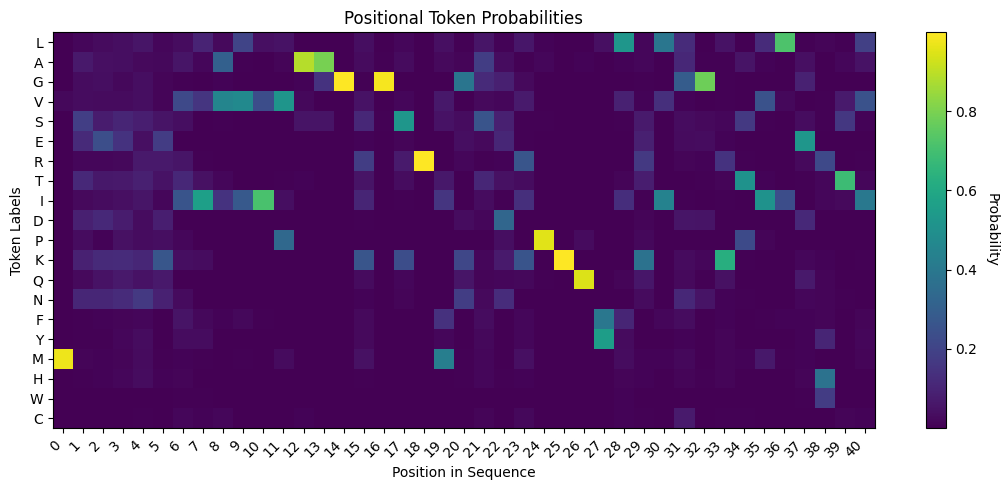

In [17]:
# Create heatmap
dat = probas_final[:, aa_indices]

plt.figure(figsize=(11, 5))
im = plt.imshow(dat.T, cmap='viridis', aspect='auto')

# Add color scale
cbar = plt.colorbar(im)
cbar.set_label('Probability', rotation=270, labelpad=15)

# Set y-axis labels (amino acid tokens) and x-axis labels (position in sequence)
plt.yticks(ticks=np.arange(len(aa_tokens)), labels=aa_tokens)
plt.xticks(ticks=np.arange(dat.shape[0]), labels=[str(i) for i in positions])
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_ticks_position('bottom')

# Add axes titles and main title
plt.xlabel('Position in Sequence')
plt.ylabel('Token Labels')
plt.title('Positional Token Probabilities')

# Adjust layout to prevent clipping of labels
plt.tight_layout()

plt.show()

### Mutant Discovery

We can now translate the logits/probabilities back into the sequence space, by mapping the highest probability in each position to the corresponding amino acid. 

In [18]:
# Predicted seq (Argmax --> Collect token IDs of predicted seq --> Convert to amino acids)
pred_idx_list = np.argmax(probas_final, axis=-1).tolist()
pred_seq = inferer.tokenizer.ids_to_text(pred_idx_list).replace(" ", "")

# Original seq
true_idx_list = [inferer.tokenizer.text_to_ids(seq)[i] for i in positions]
true_seq = inferer.tokenizer.ids_to_text(true_idx_list).replace(" ", "")

Let's compare the sequences and visually inspect the positions where a mutant is suggested over the wild-type. Note that the predicted sequence is displayed on the top, and the original sequence is on the bottom.

In [19]:
# Compare prediction (reconstruction) to true (input sequence)
display(pred_seq + " (Predicted Sequence)")
display(
    "".join(
        ["." if a == b else "|" for a, b in zip(pred_seq, true_seq)]
    )
)
display(true_seq + " (Input Sequence)")

'MSEENKIIVVIVAAGKGSRMGSDRPKQYLKIGGKTILEHTI (Predicted Sequence)'

'..|||.|.||.|...|.|.|.|.|....||..|..|...||'

'MSLKRKNIALIPAAGIGVRFGADKPKQYVEIGSKTVLEHVL (Input Sequence)'

Amongst the mismatches, we can:
1. Collect all positions where a mutant is suggested over the wild-type amino acid.
2. At these positions, find the mutant with the highest probability.

In [20]:
# Collect indices where a mutant is suggested over the wild-type
matches = [c1 == c2 for c1, c2 in zip(pred_seq, true_seq)]
mismatch_index = [i for i, value in enumerate(matches) if not value]

# Filter probability matrix to mismatches-only
probas_mismatch = probas_final[mismatch_index, :]

# Find index of mutant with highest likelihood
index_flat = np.argmax(probas_mismatch)
index_2d = np.unravel_index(index_flat, probas_mismatch.shape)
index_of_interest = mismatch_index[index_2d[0]]
position_of_interest = positions[index_of_interest]
print("Position:", position_of_interest)
print("Mutation:", true_seq[position_of_interest] + str(position_of_interest) + pred_seq[position_of_interest])

Position: 32
Mutation: S32G


Let's check the probability associated to mutations at this position.

In [21]:
# Sort tokens by probability
token_ids_sort = sorted(enumerate(probas_final[index_of_interest]), key=lambda x: x[1], reverse=True)
tokens_sort = [(inferer.tokenizer.vocab[i], i, p) for i, p in token_ids_sort]

tokens_sort_df = pd.DataFrame(tokens_sort, columns=['Token', 'Token ID', 'Probability'])
tokens_sort_df.head()

,Token,Token ID,Probability
0,G,6,0.777364
1,D,13,0.053317
2,N,17,0.052636
3,E,9,0.032532
4,S,8,0.023811


It's clear that for this position, the amino acid Glycine (G) has a higher likelihood than the wild-type, Serine (S). In this way, we can use ESM-2nv to design novel mutant candidates for downstream testing.

There are many ways that we can engineer candidates from ESM-2nv outputs. We can continue finding the top _n_ single-point mutants, find the top _n_ double- or multi-point mutants, randomly sample over the probability space generated by the input sequence, sample only within certain positions of interest (e.g. known active sites), etc. Through this process, a set of mutants can be developed for further _in silico_ or wet lab testing.